In [20]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import random
import torch

from torchvision import transforms
from tqdm.notebook import tqdm

from mdmm.model import MD_multi

from argparse import ArgumentParser

import h5py
import pytorch_lightning as pl
import torch

from torch.utils.data import DataLoader, random_split
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from data_utils import OneCenterLoad, TestCenterDataset, calculate_stats, ImbalancedDatasetSampler, BalancedBatchSampler, MultipleCentersSeq
from augmentations import basic_augmentations, color_augmentations, no_augmentations
from model import Classifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
class Args():
    learning_rate = 1e-4
    l2_reg = 1e-5
    batch_size = 8
    gpus = 1
    fast_dev_run = True
    name = 'debug'
    description = 'weighted'
    weighted = True
    max_epochs = 1
args = Args()

In [3]:
center = 0
data_file = '/home/haicu/sophia.wagner/datasets/2101_camelyon17/'
%time train_dataset = OneCenterLoad(data_file, center, 'train', transform=None)
%time val_dataset = OneCenterLoad(data_file, center, 'val', transform=None)

CPU times: user 8.53 s, sys: 27.4 s, total: 35.9 s
Wall time: 1min
CPU times: user 2.11 s, sys: 8.5 s, total: 10.6 s
Wall time: 25 s


In [4]:
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1)

In [5]:
# parser = pl.Trainer.add_argparse_args(args)
model = Classifier(args.learning_rate, args.l2_reg, weighted=args.weighted, mdmm_aug=True)
# parser = pl.Trainer.add_argparse_args(args)
# logger = TensorBoardLogger('lightning_logs', name=args.name)

# trainer = pl.Trainer(
#     gpus = args.gpus,
#     logger = logger,
# #     callbacks = [checkpoint_callback, early_stop_callback],
# #     fast_dev_run = args.fast_dev_run,
#     weights_summary=None,
#     max_epochs = args.max_epochs,
#     log_every_n_steps = 10,
# #     num_sanity_val_steps=0,
#     limit_train_batches=0.1,
#     limit_val_batches=0.5,
#     limit_test_batches=0.1,
# )
# trainer.fit(model, val_loader, val_loader)

In [13]:
# model_file = '/home/haicu/sophia.wagner/projects/stain_color/mdmm_model/results/reproduce_results_test/00007.pth' # until 0007.pth
model_file = '/home/haicu/sophia.wagner/projects/stain_color/mdmm_model/temp_results/temp/00004.pth' # until 0007.pth
model_file = '/home/haicu/sophia.wagner/projects/stain_color/MDMM/results/reproduce_results/00079.pth' # until 0007.pth

In [14]:
# options for the model, default arguments + commandline arguments
class Args:
    concat = 1
    crop_size = 216 # only used as an argument for training
    dis_norm = None
    dis_scale = 3
    dis_spectral_norm = False
    dataroot ='data'
    gpu = 0
    input_dim = 3
    isDcontent = False
    nThreads = 4
    num_domains = 5
    nz = 8
    resume = model_file
opts = Args()

In [15]:
from mdmm.model import MD_multi

# model
print('--- load model ---')
model = MD_multi(opts)
model.resume(model_file, train=False)
model.eval(); # remove ; to output architecture of the network

--- load model ---


In [16]:
            mean_domains = torch.Tensor([
                [ 0.3020, -2.6476, -0.9849, -0.7820, -0.2746,  0.3361,  0.1694, -1.2148],
                [ 0.1453, -1.2400, -0.9484,  0.9697, -2.0775,  0.7676, -0.5224, -0.2945],
                [ 2.1067, -1.8572,  0.0055,  1.2214, -2.9363,  2.0249, -0.4593, -0.9771],
                [ 0.8378, -2.1174, -0.6531,  0.2986, -1.3629, -0.1237, -0.3486, -1.0716],
                [ 1.6073,  1.9633, -0.3130, -1.9242, -0.9673,  2.4990, -2.2023, -1.4109],
            ])

            std_domains = torch.Tensor([
                [0.6550, 1.5427, 0.5444, 0.7254, 0.6701, 1.0214, 0.6245, 0.6886],
                [0.4143, 0.6543, 0.5891, 0.4592, 0.8944, 0.7046, 0.4441, 0.3668],
                [0.5576, 0.7634, 0.7875, 0.5220, 0.7943, 0.8918, 0.6000, 0.5018],
                [0.4157, 0.4104, 0.5158, 0.3498, 0.2365, 0.3612, 0.3375, 0.4214],
                [0.6154, 0.3440, 0.7032, 0.6220, 0.4496, 0.6488, 0.4886, 0.2989],
            ])

In [17]:
img = train_dataset.data['patches'][0]

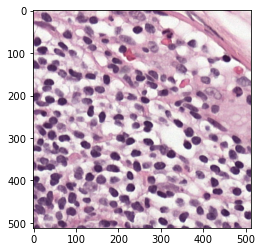

In [18]:
plt.imshow(img.permute(1, 2, 0))

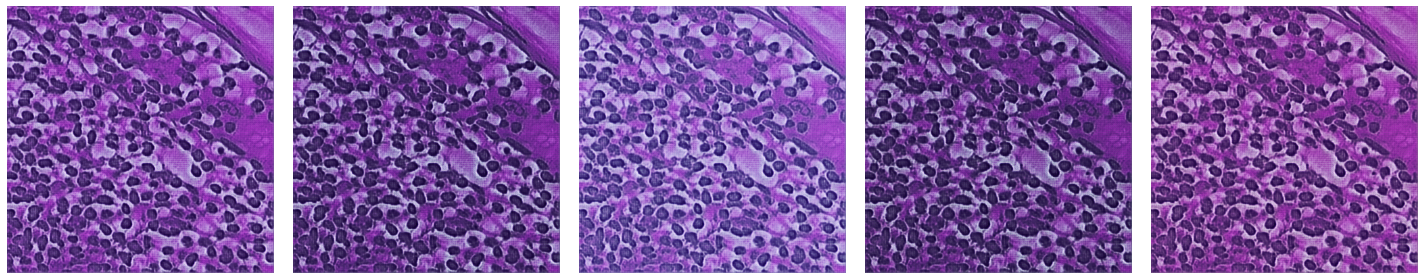

In [19]:
rows, columns, img_size = 1, 5, 4
plt.figure(figsize=(columns * img_size, rows * img_size))
for i in range(rows * columns):
    z_attr = (torch.randn((1, 8, )) * std_domains[i] + mean_domains[i])
    domain = torch.eye(5)[i].unsqueeze(0)

    z_content = model.enc_c(img.sub(0.5).mul(2).unsqueeze(0))
    out = model.gen(z_content, z_attr, domain).detach().squeeze(0) # in range [-1, 1]

    plt.subplot(rows, columns, i + 1)
    plt.imshow(out.add(1).div(2).permute(1, 2, 0))
    plt.axis('off')
plt.tight_layout()

In [42]:
geom = np.array([
    [0.819, 0.8525, 0.8509, 0.7929, 0.7155],
    [0.7812, 0.8179, 0.9087, 0.8102, 0.732],     
    [0.7896, 0.8642, 0.9294, 0.7641, 0.8253], 
])

color = np.array([
    [0.8389, 0.8898, 0.9715, 0.5842, 0.8602],    
    [0.8483, 0.8561, 0.972, 0.6385, 0.8512],
])

ours = np.array([
    [0.8591, 0.9129, 0.969, 0.9425, 0.932],
    [0.8641, 0.9096, 0.9674, 0.927, 0.933],
    [0.8153, 0.9122, 0.9593, 0.9228, 0.921], 
])

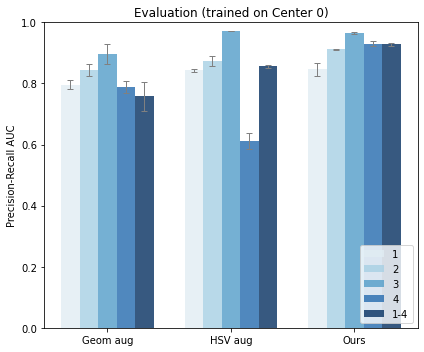

In [45]:
# labels = ['no aug','geom aug', 'basic aug', 'color aug', 'mdmm+geom aug']#, 'mdmm/color aug']
# labels = ['no aug', 'basic aug', 'reinhard norm', 'color aug', 'mdmm+geom aug']#, 'mdmm/color aug']
# labels = ['no aug', 'basic aug', 'color aug', 'mdmm+geom aug']#, 'mdmm/color aug']
labels = ['Geom aug', 'HSV aug', 'Ours']#, 'mdmm/color aug']

metric = np.array([[0.7839, 0.7844, 0.9459, 0.7994, 0.7733],
# [0.9508, 0.819, 0.8525, 0.8509, 0.7929, 0.7155] 	
[ 0.7889, 0.9181, 0.9476, 0.9022, 0.8631], 
# [0.8477, 0.7171, 0.8353, 0.8443, 0.9141, 0.7573]	
# [0.9425, 0.8251, 0.8944, 0.9693, 0.6115, 0.8538] 
[ 0.8389, 0.8898, 0.9715, 0.5842, 0.8602],
# [0.9533, 0.8094, 0.8243, 0.9479, 0.6107, 0.7712] 
[ 0.8591, 0.9129, 0.969, 0.9425, 0.932],
])

metric = np.array([
#     np.mean(no_aug, axis=0),
#     np.mean(basic, axis=0),
    np.mean(geom, axis=0),
    np.mean(color, axis=0),
    np.mean(ours, axis=0),    
])

error = np.array([
#     np.std(no_aug, axis=0),
#     np.std(basic, axis=0),
    np.std(geom, axis=0),
    np.std(color, axis=0),
    np.std(ours, axis=0),    
])


x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

cmap = plt.get_cmap('RdBu')

fig, ax = plt.subplots(figsize=(6, 5))
# rects0 = ax.bar(x - 2.5*width, list(metric[:, 0]), width, label='0', color=cmap(0.1))
rects1 = ax.bar(x - 2*width, list(metric[:, 0]), width, yerr=error[:, 0], alpha=0.8, label='1',   color=cmap(5/9), error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
rects2 = ax.bar(x - 1*width, list(metric[:, 1]), width, yerr=error[:, 1], alpha=0.8, label='2',   color=cmap(6/9), error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
rects3 = ax.bar(x + 0*width, list(metric[:, 2]), width, yerr=error[:, 2], alpha=0.8, label='3',   color=cmap(7/9), error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
rects4 = ax.bar(x + 1*width, list(metric[:, 3]), width, yerr=error[:, 3], alpha=0.8, label='4',   color=cmap(8/9), error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
rects5 = ax.bar(x + 2*width, list(metric[:, 4]), width, yerr=error[:, 4], alpha=0.8, label='1-4', color=cmap(9/9), error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Precision-Recall AUC')
ax.set_title('Evaluation (trained on Center 0)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)
# autolabel(rects3)
# autolabel(rects4)
# autolabel(rects5)
# autolabel(rects0)


fig.tight_layout()
plt.ylim([0, 1])

plt.show()

In [40]:
# no_aug = np.array([
#     [0.7839, 0.7844, 0.9459, 0.7994, 0.7733],
#     [0.6062, 0.6301, 0.8791, 0.6802, 0.7479],
#     [0.5232, 0.7429, 0.8819, 0.8395, 0.7665],
# ])

# basic = np.array([
#     [0.3827, 0.8533, 0.9092, 0.8307, 0.7419],
#     [0.366, 0.8047, 0.917, 0.8834, 0.7314],
#     [0.3383, 0.7339, 0.8815, 0.8793, 0.6865],
# ])
geom = np.array([
    [0.3095, 0.7792, 0.8185, 0.6993, 0.6202],
    [0.2573, 0.7528, 0.87, 0.7705, 0.6054],
    [0.4545, 0.8026, 0.8985, 0.6694, 0.7451],
])

color = np.array([
    [0.3912, 0.8236, 0.9341, 0.6097, 0.73],
    [0.2598, 0.7478, 0.9199, 0.6062, 0.6191],
])

ours = np.array([
    [0.6445, 0.8601, 0.8533, 0.9141, 0.8264],
    [0.7601, 0.8679, 0.9135, 0.9084, 0.878],
    [0.5809, 0.8679, 0.8868, 0.9023, 0.8283],
])

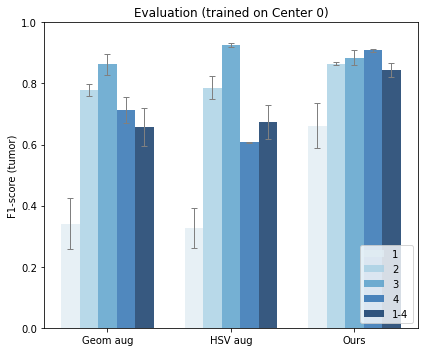

In [41]:
# labels = ['no aug','geom aug', 'basic aug', 'color aug', 'mdmm+geom aug']#, 'mdmm/color aug']
# labels = ['no aug', 'basic aug','reinhard norm', 'color aug', 'mdmm+geom aug']#, 'mdmm/color aug']
# labels = ['no aug', 'basic aug', 'color aug', 'Ours']#, 'mdmm/color aug']
labels = ['Geom aug', 'HSV aug', 'Ours']#, 'mdmm/color aug']


metric = np.array([[ 0.7839, 0.7844, 0.9459, 0.7994, 0.7733],
# [0.9173, 0.3095, 0.7792, 0.8185, 0.6993, 0.6202]
[0.3827, 0.8533, 0.9092, 0.8307, 0.7419],
# [0.2592, 0.7018, 0.7807, 0.8584, 0.5884],
# [0.8595, 0.268, 0.8005, 0.9203, 0.6172, 0.64]
[0.3912, 0.8236, 0.9341, 0.6097, 0.73], 
# [0.4022, 0.7572, 0.918, 0.44, 0.6975],  
[0.6445, 0.8601, 0.8533, 0.9141, 0.8264],
])

metric = np.array([
#     np.mean(no_aug, axis=0),
#     np.mean(basic, axis=0),
    np.mean(geom, axis=0),
    np.mean(color, axis=0),
    np.mean(ours, axis=0),    
])

error = np.array([
#     np.std(no_aug, axis=0),
#     np.std(basic, axis=0),
    np.std(geom, axis=0),
    np.std(color, axis=0),
    np.std(ours, axis=0),    
])


x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

cmap = plt.get_cmap('RdBu')

fig, ax = plt.subplots(figsize=(6, 5))
# rects0 = ax.bar(x - 2.5*width, list(metric[:, 0]), width, label='0', color=cmap(0.1))
rects1 = ax.bar(x - 2*width, list(metric[:, 0]), width, yerr=error[:, 0], alpha=0.8, label='1',   color=cmap(5/9), error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
rects2 = ax.bar(x - 1*width, list(metric[:, 1]), width, yerr=error[:, 1], alpha=0.8, label='2',   color=cmap(6/9), error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
rects3 = ax.bar(x + 0*width, list(metric[:, 2]), width, yerr=error[:, 2], alpha=0.8, label='3',   color=cmap(7/9), error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
rects4 = ax.bar(x + 1*width, list(metric[:, 3]), width, yerr=error[:, 3], alpha=0.8, label='4',   color=cmap(8/9), error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
rects5 = ax.bar(x + 2*width, list(metric[:, 4]), width, yerr=error[:, 4], alpha=0.8, label='1-4', color=cmap(9/9), error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1-score (tumor)')
ax.set_title('Evaluation (trained on Center 0)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)

fig.tight_layout()
plt.ylim([0, 1])
plt.show()

In [36]:
geom_val = np.array([
    [0.9508, 0.9500, 0.9557],  # results for center 0
    [0.7059, 0.6909, 0.7257],  # results for center 1
    [0.6591, 0.6968, 0.6540],  # results for center 2
    [0.9873, 0.9877, 0.9878],  # results for center 3
    [0.8527, 0.8395, 0.8573]  # results for center 4
])

geom = np.array([
    [0.5908, 0.6525, 0.5630, 0.7265, 0.7471, 0.5348, 0.6866, 0.7284, 0.8213, 0.8193, 0.8606, 0.7471],  # results for center 0
    [0.8190, 0.7812, 0.7896, 0.1041, 0.0735, 0.0305, 0.7499, 0.7785, 0.7272, 0.5839, 0.5872, 0.6765],  # results for center 1
    [0.8525, 0.8179, 0.8642, 0.4663, 0.4756, 0.5293, 0.1584, 0.2194, 0.2389, 0.6696, 0.5758, 0.5081],  # results for center 2
    [0.8509, 0.9087, 0.9294, 0.6161, 0.7331, 0.6115, 0.6720, 0.5414, 0.2463, 0.8985, 0.8923, 0.9289],  # results for center 3
    [0.7929, 0.8102, 0.7641, 0.8012, 0.8013, 0.7695, 0.9310, 0.9162, 0.8884, 0.5055, 0.7359, 0.7606],  # results for center 4
])


color = np.array([
    [0.6836, 0.8750, 0.8176, 0.7524, 0.6663, 0.6780, 0.8176, 0.8220, 0.7756, 0.7524, 0.8352, 0.7381],  # results for center 0
    [0.8251, 0.8483, 0.7718, 0.5935, 0.6140, 0.6130, 0.8666, 0.8682, 0.8512, 0.7769, 0.8206, 0.7455],  # results for center 1
    [0.8944, 0.8561, 0.8959, 0.4663, 0.4756, 0.5293, 0.7683, 0.7430, 0.7750, 0.7090, 0.7159, 0.6053],  # results for center 2
    [0.9435, 0.9228, 0.9693, 0.9720, 0.9681, 0.9001, 0.8072, 0.8754, 0.9458, 0.9292, 0.9447, 0.9129],  # results for center 3
    [0.6385, 0.6169, 0.9016, 0.9275, 0.6115, 0.8792, 0.6724, 0.6736, 0.9206, 0.9021, 0.9334, 0.9235],  # results for center 4
])	

ours = np.array([
    [0.8994, 0.9000, 0.8947, 0.8983, 0.8809, 0.9027, 0.9052, 0.8744, 0.9030, 0.8859, 0.8787, 0.8547], # results for center 0
    [0.8641, 0.7430, 0.8192, 0.8591, 0.8153, 0.7285, 0.7878, 0.7473, 0.8119, 0.7667, 0.6561, 0.6478], # results for center 1
    [0.9096, 0.6325, 0.9227, 0.9129, 0.9122, 0.6368, 0.7065, 0.8567, 0.8562, 0.8956, 0.8914, 0.8768], # results for center 2
    [0.9674, 0.9691, 0.9296, 0.9690, 0.9593, 0.9559, 0.9496, 0.9478, 0.9406, 0.9654, 0.9391, 0.9454], # results for center 3
    [0.9270, 0.9439, 0.9380, 0.9425, 0.9228, 0.9135, 0.9303, 0.9323, 0.9391, 0.9263, 0.9385, 0.9249], #, 0.9263], # results for center 4
])

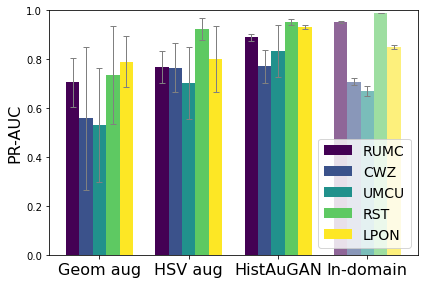

In [28]:
# import matplotlib.pyplot as plt
# plt.rcParams["font.family"] = "Times New Roman"
csfont = {'fontname':'Times New Roman'}

labels = ['Geom aug', 'HSV aug', 'HistAuGAN', 'In-domain']#, 'mdmm/color aug']


metric = np.array([
#     np.mean(no_aug, axis=0),
#     np.mean(basic, axis=0),
    np.mean(geom, axis=1),
    np.mean(color, axis=1),
    np.mean(ours, axis=1),   
    np.mean(geom_val, axis=1),
])

error = np.array([
#     np.std(no_aug, axis=0),
#     np.std(basic, axis=0),
    np.std(geom, axis=1),
    np.std(color, axis=1),
    np.std(ours, axis=1),    
    np.std(geom_val, axis=1),
])



x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

cmap = plt.get_cmap('viridis')

fig, ax = plt.subplots(figsize=(6, 4))
# rects0 = ax.bar(x - 2.5*width, list(metric[:, 0]), width, label='0', color=cmap(0.1))
rects1 = ax.bar(x - 2*width, list(metric[:, 0]), width, yerr=error[:, 0], label='RUMC', color=[cmap(0/4), cmap(0/4), cmap(0/4), cmap(0/4, alpha=0.6)], error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
rects2 = ax.bar(x - 1*width, list(metric[:, 1]), width, yerr=error[:, 1], label='CWZ',  color=[cmap(1/4), cmap(1/4), cmap(1/4), cmap(1/4, alpha=0.6)], error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
rects3 = ax.bar(x + 0*width, list(metric[:, 2]), width, yerr=error[:, 2], label='UMCU', color=[cmap(2/4), cmap(2/4), cmap(2/4), cmap(2/4, alpha=0.6)], error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
rects4 = ax.bar(x + 1*width, list(metric[:, 3]), width, yerr=error[:, 3], label='RST',  color=[cmap(3/4), cmap(3/4), cmap(3/4), cmap(3/4, alpha=0.6)], error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
rects5 = ax.bar(x + 2*width, list(metric[:, 4]), width, yerr=error[:, 4], label='LPON', color=[cmap(4/4), cmap(4/4), cmap(4/4), cmap(4/4, alpha=0.6)], error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
# rects1 = ax.bar(x - 2*width, list(metric[:, 0]), width, yerr=error[:, 0], alpha=0.8, label='RUMC', color=cmap(0/4), error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
# rects2 = ax.bar(x - 1*width, list(metric[:, 1]), width, yerr=error[:, 1], alpha=0.8, label='CWZ',  color=cmap(1/4), error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
# rects3 = ax.bar(x + 0*width, list(metric[:, 2]), width, yerr=error[:, 2], alpha=0.8, label='UMCU', color=cmap(2/4), error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
# rects4 = ax.bar(x + 1*width, list(metric[:, 3]), width, yerr=error[:, 3], alpha=0.8, label='RST',  color=cmap(3/4), error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
# rects5 = ax.bar(x + 2*width, list(metric[:, 4]), width, yerr=error[:, 4], alpha=0.8, label='LPON', color=cmap(4/4), error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('PR-AUC', fontsize=16)
# ax.set_title('Evaluation (results on non-training center)') #, **csfont)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=16)
ax.legend(loc='lower right', fontsize=14)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)
# import matplotlib.pyplot as plt
# SMALL_SIZE = 8
# MEDIUM_SIZE = 10

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rc('text', usetex=True)
# plt.rc('text.latex', unicode=True)

# matplotlib.rcParams['text.usetex']=True
# import matpotlib
# matplotlib.rcParams['text.latex.unicode']=True

fig.tight_layout()
plt.ylim([0, 1])
plt.savefig('pr_auc.pdf')
plt.show()

In [32]:
geom_val = np.array([
    [0.9173, 0.9084, 0.9079],  # results for center 0
    [0.4791, 0.5321, 0.6555],  # results for center 1
    [0.5959, 0.6307, 0.5824],  # results for center 2
    [0.9710, 0.9718, 0.969],  # results for center 3
    [0.8235, 0.8302, 0.8302],  # results for center 4
])

geom = np.array([
    [0.5895, 0.5426, 0.4915, 0.7024, 0.6988, 0.4645, 0.6985, 0.6408, 0.6556, 0.7320, 0.7065, 0.5964],
    [0.3095, 0.2573, 0.4545, 0.0818, 0.0288, 0.0018, 0.2789, 0.2799, 0.3072, 0.5694, 0.5497, 0.4353],
    [0.7792, 0.7528, 0.8026, 0.3276, 0.3845, 0.5043, 0.0392, 0.0520, 0.0672, 0.4917, 0.3539, 0.3297],
    [0.8185, 0.8700, 0.8985, 0.5598, 0.6965, 0.5202, 0.6351, 0.3685, 0.1012, 0.8391, 0.8317, 0.8037],
    [0.6993, 0.7705, 0.6694, 0.4215, 0.3592, 0.4797, 0.8315, 0.6929, 0.8534, 0.4741, 0.6781, 0.7439], 
])

color = np.array([
    [0.6456, 0.6185, 0.6613, 0.3932, 0.3815, 0.4237, 0.748 , 0.7647, 0.7437, 0.7037, 0.7763, 0.6965],
    [0.2680, 0.2598, 0.4481, 0.2728, 0.3022, 0.2771, 0.6129, 0.6922, 0.7515, 0.7506, 0.7398, 0.729],
    [0.8005, 0.7478, 0.8067, 0.3898, 0.3934, 0.4555, 0.4489, 0.6388, 0.5796, 0.7067, 0.7097, 0.6163],
    [0.9203, 0.9199, 0.9238, 0.8580, 0.7511, 0.8491, 0.7814, 0.8357, 0.8372, 0.8895, 0.8888, 0.8796],
    [0.6172, 0.6062, 0.7073, 0.6590, 0.6452, 0.6840, 0.8552, 0.8433, 0.8508, 0.8950, 0.9189, 0.8701],
]) 

ours = np.array([
    [0.8545, 0.7644, 0.7360, 0.7235, 0.4183, 0.6752, 0.7632, 0.7884, 0.8058, 0.7153, 0.6979, 0.6639],
    [0.6445, 0.7601, 0.5809, 0.4753, 0.1489, 0.5361, 0.6772, 0.6833, 0.6687, 0.6356, 0.4784, 0.5342],
    [0.8601, 0.8679, 0.8679, 0.6505, 0.6081, 0.7098, 0.8825, 0.7923, 0.8060, 0.8343, 0.7371, 0.8340],
    [0.8533, 0.9135, 0.8868, 0.8878, 0.7810, 0.8526, 0.8741, 0.4723, 0.8186, 0.8872, 0.8410, 0.8936],
    [0.9141, 0.9084, 0.9023, 0.8065, 0.8404, 0.8968, 0.9013, 0.6993, 0.9251, 0.7557, 0.7425, 0.7459], 
])
  

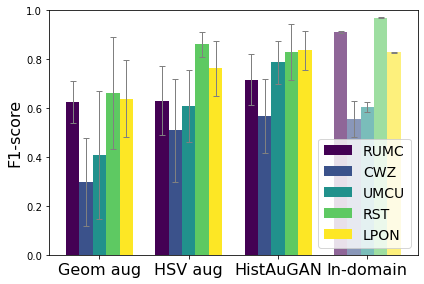

In [31]:
# import matplotlib.pyplot as plt
# plt.rcParams["font.family"] = "Times New Roman"
csfont = {'fontname':'Times New Roman'}

labels = ['Geom aug', 'HSV aug', 'HistAuGAN', 'In-domain']#, 'mdmm/color aug']


metric = np.array([
#     np.mean(no_aug, axis=0),
#     np.mean(basic, axis=0),
    np.mean(geom, axis=1),
    np.mean(color, axis=1),
    np.mean(ours, axis=1),   
    np.mean(geom_val, axis=1),
])

error = np.array([
#     np.std(no_aug, axis=0),
#     np.std(basic, axis=0),
    np.std(geom, axis=1),
    np.std(color, axis=1),
    np.std(ours, axis=1),    
    np.std(geom_val, axis=1),
])


x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

cmap = plt.get_cmap('viridis')

fig, ax = plt.subplots(figsize=(6, 4))
# rects0 = ax.bar(x - 2.5*width, list(metric[:, 0]), width, label='0', color=cmap(0.1))
# rects1 = ax.bar(x - 2*width, list(metric[:, 0]), width, yerr=error[:, 0], alpha=0.8, label='RUMC', color=cmap(0/4), error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
# rects2 = ax.bar(x - 1*width, list(metric[:, 1]), width, yerr=error[:, 1], alpha=0.8, label='CWZ',  color=cmap(1/4), error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
# rects3 = ax.bar(x + 0*width, list(metric[:, 2]), width, yerr=error[:, 2], alpha=0.8, label='UMCU', color=cmap(2/4), error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
# rects4 = ax.bar(x + 1*width, list(metric[:, 3]), width, yerr=error[:, 3], alpha=0.8, label='RST',  color=cmap(3/4), error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
# rects5 = ax.bar(x + 2*width, list(metric[:, 4]), width, yerr=error[:, 4], alpha=0.8, label='LPON', color=cmap(4/4), error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
rects1 = ax.bar(x - 2*width, list(metric[:, 0]), width, yerr=error[:, 0], label='RUMC', color=[cmap(0/4), cmap(0/4), cmap(0/4), cmap(0/4, alpha=0.6)], error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
rects2 = ax.bar(x - 1*width, list(metric[:, 1]), width, yerr=error[:, 1], label='CWZ',  color=[cmap(1/4), cmap(1/4), cmap(1/4), cmap(1/4, alpha=0.6)], error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
rects3 = ax.bar(x + 0*width, list(metric[:, 2]), width, yerr=error[:, 2], label='UMCU', color=[cmap(2/4), cmap(2/4), cmap(2/4), cmap(2/4, alpha=0.6)], error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
rects4 = ax.bar(x + 1*width, list(metric[:, 3]), width, yerr=error[:, 3], label='RST',  color=[cmap(3/4), cmap(3/4), cmap(3/4), cmap(3/4, alpha=0.6)], error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))
rects5 = ax.bar(x + 2*width, list(metric[:, 4]), width, yerr=error[:, 4], label='LPON', color=[cmap(4/4), cmap(4/4), cmap(4/4), cmap(4/4, alpha=0.6)], error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=1))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1-score', fontsize=16)
# ax.set_title('Evaluation (results on non-training center)') #, **csfont)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=16)
ax.legend(loc='lower right', fontsize=14)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)
# import matplotlib.pyplot as plt
# SMALL_SIZE = 8
# MEDIUM_SIZE = 10

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rc('text', usetex=True)
# plt.rc('text.latex', unicode=True)

# matplotlib.rcParams['text.usetex']=True
# import matpotlib
# matplotlib.rcParams['text.latex.unicode']=True

fig.tight_layout()
plt.ylim([0, 1])
plt.savefig('f1_score.pdf')
plt.show()

In [42]:
cmap(0)

(0.267004, 0.004874, 0.329415, 1.0)

In [38]:
cmap(0.25)

(0.229739, 0.322361, 0.545706, 1.0)

In [39]:
cmap(0.5)

(0.127568, 0.566949, 0.550556, 1.0)

In [37]:
np.std(ours)

0.08722321522966234

In [38]:
np.std(geom)

0.2242771496014102

In [39]:
np.std(color)

0.12834355223383836